Usando dispositivo: cuda


100%|██████████| 9.91M/9.91M [00:01<00:00, 4.98MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 305kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 1.90MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 26.5MB/s]



Dimensiones de un lote de imágenes: torch.Size([128, 1, 28, 28])
Dimensiones de un lote de etiquetas: torch.Size([128])
SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Iniciando entrenamiento...
Época [1/10] - Pérdida (Entrenamiento): 0.3588 - Pérdida (Validación): 0.0685 - Precisión (Validación): 97.73%
Época [2/10] - Pérdida (Entrenamiento): 0.1153 - Pérdida (Validación): 0.0489 - Precisión (Validación): 98.35%
Época [3/10] - Pérdida (

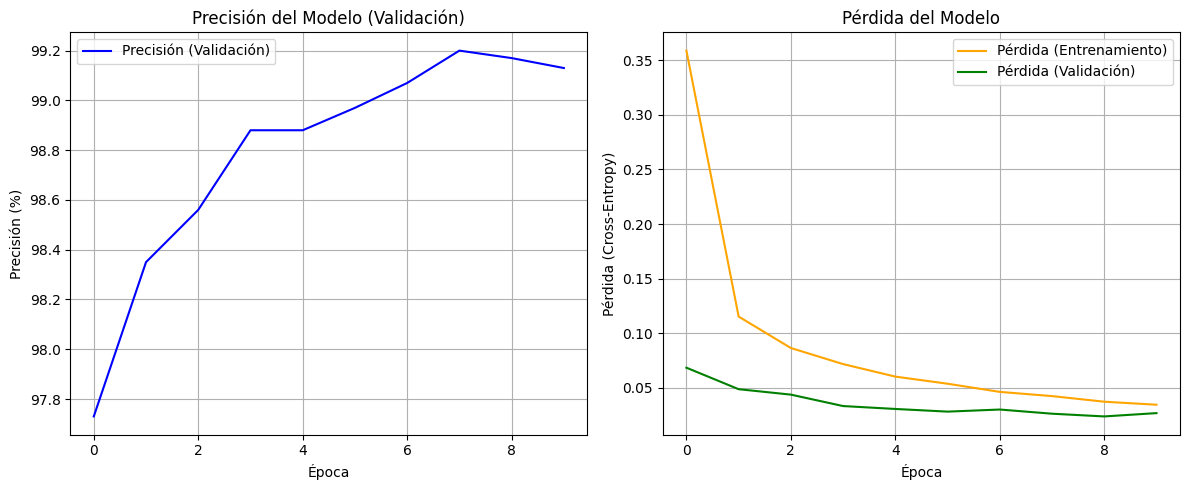

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

# --- 0. Definir Hiperparámetros y Dispositivo ---
EPOCHS = 10
BATCH_SIZE = 128
LEARNING_RATE = 0.001

# Configurar el dispositivo (GPU si está disponible, sino CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# --- 1. Carga y Preparación de Datos ---

# PyTorch usa 'transforms' para preprocesar datos.
# ToTensor() convierte la imagen PIL/Numpy a un Tensor
# y normaliza los píxeles del rango [0, 255] a [0, 1].
transform = ToTensor()

# Descargar datos de entrenamiento
train_dataset = datasets.MNIST(
    root="./data",  # Directorio donde se guardan los datos
    train=True,
    download=True,
    transform=transform
)

# Descargar datos de prueba
test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

# Crear 'DataLoaders' para manejar los lotes (batches)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True  # Mezclar los datos de entrenamiento
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Verificación de las dimensiones (N_lote, Canales, Altura, Ancho)
# Note la diferencia con Keras (N, H, W, C)
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"\nDimensiones de un lote de imágenes: {images.shape}") # (128, 1, 28, 28)
print(f"Dimensiones de un lote de etiquetas: {labels.shape}") # (128)

# --- 2. Construcción de la Arquitectura CNN ---

# En PyTorch, los modelos se definen como clases que heredan de nn.Module
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Bloque Extractor 1
        # nn.Conv2d(canales_entrada, canales_salida, kernel_size)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bloque Extractor 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bloque Clasificador (MLP)
        self.flatten = nn.Flatten()
        # Cálculo de la entrada a la capa densa:
        # (N, 64, 7, 7) -> 64 * 7 * 7 = 3136
        self.fc1 = nn.Linear(in_features=64 * 7 * 7, out_features=128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=128, out_features=10) # 10 clases de salida

    # El método 'forward' define cómo fluyen los datos a través de las capas
    def forward(self, x):
        # Bloque 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Bloque 2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Clasificador
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x) # Salida de logits (sin softmax)

        return x

# Instanciar el modelo y moverlo al dispositivo (GPU/CPU)
model = SimpleCNN().to(device)
print(model)

# --- 3. Definición de Pérdida y Optimizador ---

# nn.CrossEntropyLoss aplica internamente Softmax y la pérdida
# Por eso, el modelo debe retornar los logits "crudos".
criterion = nn.CrossEntropyLoss()

# Optimizador Adam
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- 4. Bucle de Entrenamiento ---

# Listas para guardar el historial de la métrica
train_losses = []
val_losses = []
val_accuracies = []

print("\nIniciando entrenamiento...")

for epoch in range(EPOCHS):

    # ---- Fase de Entrenamiento ----
    model.train() # Poner el modelo en modo entrenamiento (activa Dropout)
    running_loss = 0.0

    for batch_idx, (data, targets) in enumerate(train_loader):
        # Mover datos al dispositivo
        data = data.to(device)
        targets = targets.to(device)

        # 1. Poner a cero los gradientes
        optimizer.zero_grad()

        # 2. Forward pass (predicción)
        outputs = model(data)

        # 3. Calcular la pérdida
        loss = criterion(outputs, targets)

        # 4. Backward pass (retropropagación)
        loss.backward()

        # 5. Actualizar pesos
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- Fase de Validación ----
    model.eval() # Poner el modelo en modo evaluación (desactiva Dropout)
    running_val_loss = 0.0
    correct = 0
    total = 0

    # Desactivar el cálculo de gradientes para la validación
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item()

            # Calcular la precisión
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    avg_val_loss = running_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)

    print(f"Época [{epoch+1}/{EPOCHS}] - "
          f"Pérdida (Entrenamiento): {avg_train_loss:.4f} - "
          f"Pérdida (Validación): {avg_val_loss:.4f} - "
          f"Precisión (Validación): {accuracy:.2f}%")

print("Entrenamiento finalizado.")

# --- 5. Visualización de Resultados ---

plt.figure(figsize=(12, 5))

# Gráfico de Precisión (usando val_accuracies)
plt.subplot(1, 2, 1)
plt.plot(val_accuracies, label='Precisión (Validación)', color='blue')
plt.title('Precisión del Modelo (Validación)')
plt.xlabel('Época')
plt.ylabel('Precisión (%)')
plt.legend()
plt.grid(True)

# Gráfico de Pérdida
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Pérdida (Entrenamiento)', color='orange')
plt.plot(val_losses, label='Pérdida (Validación)', color='green')
plt.title('Pérdida del Modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida (Cross-Entropy)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()